In [1]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from functions.arma import ARMA
from functions.adf_check import adf_check
from functions.best_model_arma import best_model_arma
from functions.ar import AR
from functions.ma import MA
from functions.acf_pacf import acf_pacf
from functions.ols_linear_reg import ols_linear_regression
from functions.ols_pred import predict_ols_linear_regression


# Part 1: Data cleaning and processing

In [2]:
df = load_data_parquet()
df = data_by_country(df)
df = df.dropna()


c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt", "Country_ISO"]


In [3]:
# To show how the ARMA model works, I've picked Sweden
df = df[df["Country"]=="Sweden"]

In [57]:
# Choosing some data to make the arima model with
df = df.loc[(df.dt >= "1950-01-01") & (df.dt <= "2013-08-01")]

df2 = df.loc[(df.dt >= "2000-01-01") & (df.dt <= "2003-12-01")]

In [58]:

df2 = df2[["dt","AverageTemperature"]]
df2 = df2.set_index("dt")

df = df[["dt","AverageTemperature"]]
df = df.set_index("dt")

## First we look at the time series...

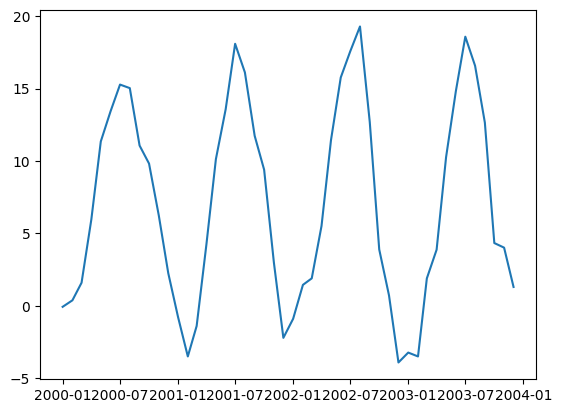

In [6]:
plt.plot(df2["AverageTemperature"])

## Then we have to make the data stationary

Sources: 
https://github.com/jinit24/ARIMA-Model/blob/master/ARIMA.ipynb 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://puneet166.medium.com/time-series-forecasting-how-to-predict-future-data-using-arma-arima-and-sarima-model-8bd20597cc7b

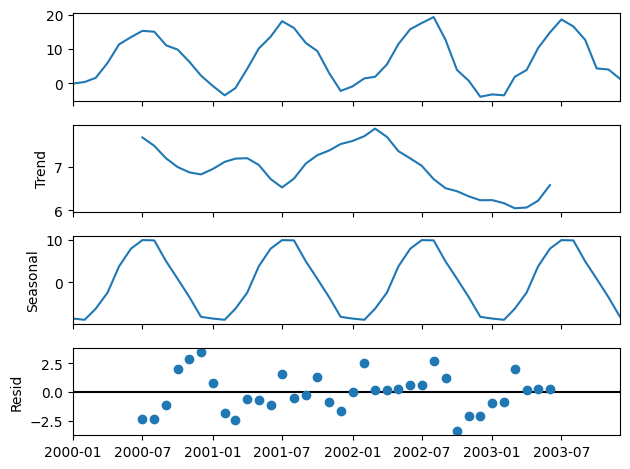

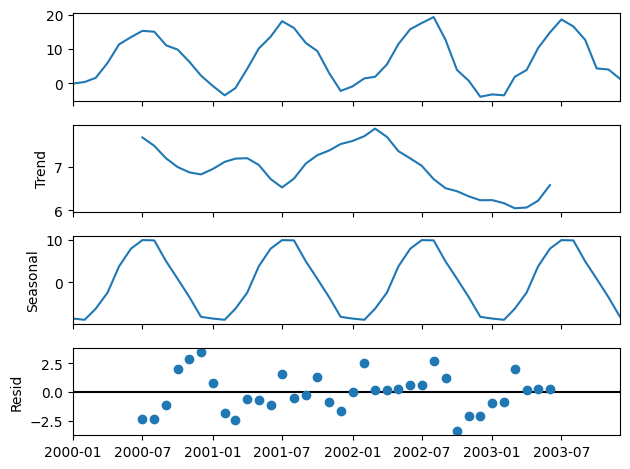

In [7]:

decompose_data = seasonal_decompose(df2, model="additive",period=12)
decompose_data.plot()

The Augmented Dickey-Fuller (ADF) test is used to check whether a time series is stationary or non-stationary by assessing the presence of a unit root. Stationary time series have constant statistical properties, while non-stationary time series exhibit changing properties over time. The ADF test formulates hypotheses and computes a test statistic and p-value, allowing you to determine whether the time series is stationary. Rejecting the null hypothesis suggests stationarity, while failing to reject it indicates non-stationarity. Stationarity is essential for selecting appropriate time series forecasting models, and the ADF test helps in making informed modeling decisions.

In [8]:
adf_check(df2.AverageTemperature, "AIC")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.7828846396968805
p-value : 5.077501061940117e-07
Number of Lags Used : 6
Number of Observations Used : 41
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


Stationarity and seasonality are two related but distinct concepts in time series analysis:

1. Stationarity refers to a time series maintaining consistent statistical properties over time, including a constant mean, variance, and autocorrelation. This property simplifies modeling and is desirable for forecasting.

2. Seasonality involves recurring and predictable patterns or fluctuations within a time series, often related to calendar time intervals. These patterns can be daily, weekly, monthly, or yearly and result from external factors.

Importantly, a time series can exhibit both stationarity and seasonality simultaneously. Stationarity ensures that the overall statistical characteristics remain constant, while seasonality introduces regular, calendar-driven patterns on top of this stationary baseline. The coexistence of these features is common and can be explained by understanding their distinct roles in characterizing time series data.


## Do we need to shift the data? 

https://people.duke.edu/~rnau/411arim2.htm

According to the adf_check, our data is stationary which means that we do not need to shift the data. Therefore, in this case our model becomes an ARMA model. The difference between an ARMA model and ARIMA model is the differencing (shifting) of data.

In [9]:
# Example code to remove seasonality with differencing
#df["temperatures_shifted"]= df["AverageTemperature"].shift(12)

## ACF and PACF
ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are essential tools for determining the order of autoregressive (AR) and moving average (MA) terms, denoted as "p" and "q," respectively, in time series analysis.

ACF measures the correlation between a time series and its lagged values at various lags.
PACF measures the correlation between a time series and its lagged values while removing the influence of shorter lags.
A sharp drop in the ACF plot after a certain lag suggests an AR term, and the number of significant lags helps identify "p."
A sharp drop in the PACF plot after a certain lag suggests an MA term, and the number of significant lags helps identify "q."

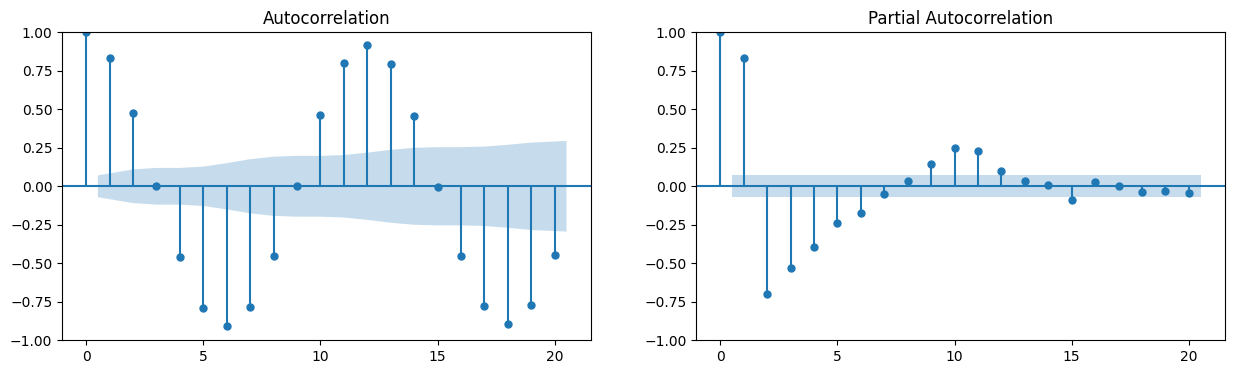

In [10]:
acf_pacf(df.AverageTemperature,20)

Based on acf, we have 2 lags, and with pacf 5 lags. Therefore, we should test the arima model from 2-5 lags

# Part 2: Fitting an Auto-Regressive (AR) model

In [59]:
# Removing columns we dont need
#df_testing = df.copy()
df_testing = df2.copy()
df_testing = df_testing[["AverageTemperature"]]

df_testing2 = df.copy()
df_testing2 = df_testing2[["AverageTemperature"]]
#df_testing

An AutoRegressive (AR) model is a fundamental time series model used for forecasting. It's a linear model that captures the relationship between a time series and its past values. The primary idea behind an AR model is that the current value of a time series can be predicted as a linear combination of its past values, often referred to as lags.

Mathematically, an $AR(p)$ model of order $p$ can be expressed as:

$ Y_t = \beta_0 + \beta_1*Y_{t-1} + \beta_2*Y_{t-2} + … + \beta_p*Y_{t-p} + ϵₜ$

Where:

* $ Y_t $ is the value of the time series at time $t$ 
* $\beta_0$ is a constant (intercept) term.
* $\beta_1, \beta_2, ..., \beta_p$ are the coefficients of the model representing the relationship between the current value and the past values.
* $ Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$ are the lagged values of the time series at time ${t-1}, {t-2}, ...,{t-p}$.
* $ ϵₜ$ is a white noise error term at time $t$, representing random fluctuations that are not explained by the model.

In the AR model, we estimate the coefficients $\beta_1, \beta_2, ..., \beta_p$ and the constant term $\beta_0$ using Ordinary Least Squares (OLS) linear regression. OLS helps us find the values of these parameters that minimize the sum of squared residuals, making our predictions as accurate as possible based on the historical data.

We split the data into 80% training data and 20% testing data.

In [12]:
[df_train_2, df_test, coef, intercept, RMSE, MSE, res] = AR(df_testing,3)

The RMSE is : 2.3547073401862875 , Value of p :  3


Plotting the predicted values vs the actual values

<Axes: xlabel='dt'>

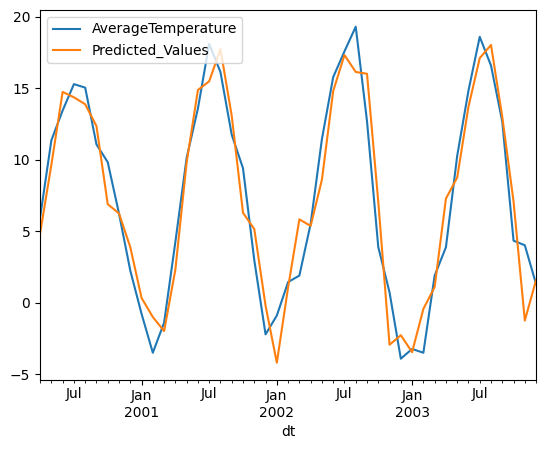

In [13]:
df_c = pd.concat([df_train_2,df_test])
df_c[['AverageTemperature','Predicted_Values']].plot()

# Part 3: Fitting the Moving Average (MA) model on residuals

A Moving Average (MA) model is another essential time series model used for forecasting. Unlike the AutoRegressive (AR) model, which focuses on the relationship between a time series and its past values, the MA model centers on capturing the relationship between the current value of a time series and its past white noise error terms.

For the MA model, we first use an AutoRegressive (AR) model to capture systematic patterns and dependencies in past values, followed by using the residuals from the AR model as inputs to the MA component. The residuals (error) comes from taking the difference between the actual value of the AR model and the predicted value.

Mathematically, an $MA(p)$ model of order $p$ can be expressed as:

$$ Y_t = \mu + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + … + \theta_p \epsilon_{t-p} + \epsilon_t $$

Where:

- $Y_t$ is the value of the time series at time $t$.
- $\mu$ is the mean or average of the time series.
- $\theta_1, \theta_2, ..., \theta_p$ are the coefficients of the model representing the relationship between the current value and the past error terms.
- $\epsilon_{t-1}, \epsilon_{t-2}, ..., \epsilon_{t-p}$ are the lagged error terms of the time series at time $t-1, t-2, ..., t-p$.
- $\epsilon_t$ is a white noise error term at time $t$, representing random fluctuations that are not explained by the model.

Both AR and MA components utilize Ordinary Least Squares (OLS) linear regression to estimate coefficients and the mean, aiming to minimize the sum of squared residuals for accurate predictions.



In [14]:
[res_train_2, res_test, coef, intercept,MSE, RMSE] = MA(res,5)

The RMSE is : 2.462197031301289 , Value of q :  5


<Axes: xlabel='dt'>

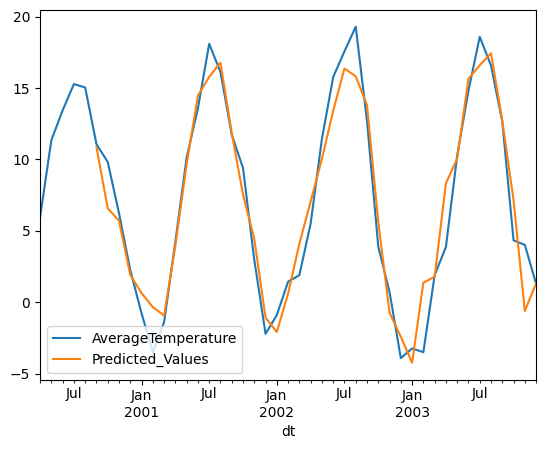

In [15]:
res_c = pd.concat([res_train_2,res_test])
df_c.Predicted_Values += res_c.Predicted_Values
df_c[['AverageTemperature','Predicted_Values']].plot()

The code "df_ar.Predicted_Values += res_c.Predicted_Values" combines predictions from an AutoRegressive (AR) model and a Moving Average (MA) model in an AutoRegressive Moving Average (ARMA) model. This combination aims to leverage the strengths of both models. The AR model captures systematic trends and dependencies on past values, while the MA model captures short-term fluctuations and unexplained variations. By adding the predictions from the MA model to the AR model's predictions, the ARMA model creates a more accurate forecast that accounts for both long-term and short-term patterns in the time series data.

# Part 4: Combine the AR(p) and MA(q) model to create an ARMA(p,q) model

An AutoRegressive Moving Average (ARMA(p, q)) model is a time series forecasting model that combines the AutoRegressive (AR) and Moving Average (MA) processes to capture and explain the underlying patterns in time series data.

Mathematically, an ARMA(p, q) model of order p and q can be expressed as:

$ Yₜ = β₀ + β₁Yₜ₋₁ + β₂Yₜ₋₂ + … + βₚYₜ₋ₚ + εₜ + θ₁εₜ₋₁ + θ₂εₜ₋₂ + … + θₚεₜ₋ₚ$
 
Where:

* $Y_t$ represents the value of the time series at time $t$.
* $\beta_0$ is a constant (intercept) term.
* $\beta_1, \beta_2, \ldots, \beta_p$ are the coefficients of the AR component, indicating the strength and direction of the relationship between the current value and its past values up to lag $p$.
* $\varepsilon_t$ is a white noise error term at time $t$, representing the random component of the current value.
* $\theta_1, \theta_2, \ldots, \theta_q$ are the coefficients of the MA component, representing the impact of past error terms on the current value up to lag $q$.
* $\varepsilon_{t-1}, \varepsilon_{t-2}, \ldots, \varepsilon_{t-q}$ are the lagged error terms at time $t-1, t-2, \ldots, t-q$.


In summary, an ARMA(p, q) model combines both the AR and MA components to create a comprehensive model for time series data. It acknowledges that the current value of the time series is influenced by its own past values (AR) and by past error terms (MA). The model is used for time series forecasting and analysis, aiming to capture and explain the patterns and dependencies in historical data to make accurate predictions about future values of the time series.

In [16]:
[df_ar,MSE,RMSE] = ARMA(df_testing,5,4)

The MSE is : 9.977471566097044 , Value of p :  5 Value of q : 4
The RMSE is : 3.158713593553085 , Value of p :  5 Value of q : 4


<Axes: xlabel='dt'>

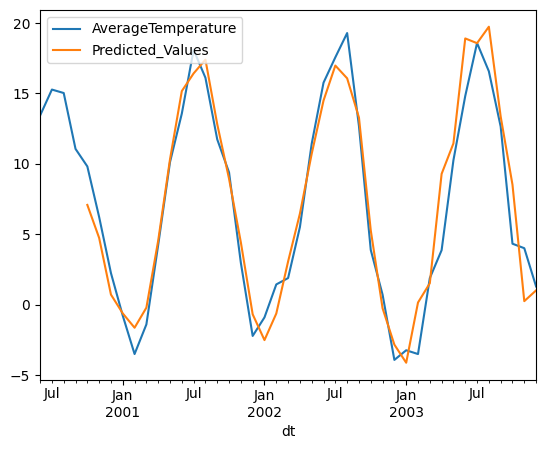

In [17]:
df_ar[["AverageTemperature", "Predicted_Values"]].plot()

# Part 5: Choosing the best model

MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) are valuable metrics for evaluating and comparing the performance of ARMA (AutoRegressive Moving Average) models, especially when choosing the best model among multiple candidates. These metrics quantify the accuracy of model predictions by measuring the squared differences between predicted and actual values in a test dataset. Lower MSE and RMSE values indicate better model performance, making them crucial for selecting the most accurate forecasting model. However, it's advisable to consider other factors like model interpretability and computational complexity alongside MSE and RMSE to make a well-informed decision about model selection.

 While MSE and RMSE are commonly used due to their simplicity and ease of interpretation, considering multiple metrics and conducting a thorough analysis of model diagnostics can lead to a more robust model selection process. 

 Examples of other metrics we could use:
 * AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These metrics take into account the model's goodness of fit and complexity, penalizing models with too many parameters. Lower AIC or BIC values indicate a better trade-off between model fit and complexity.
 * Adjusted R-squared: In regression-based models like ARMA, adjusted R-squared assesses the proportion of variance in the dependent variable that is explained by the model while accounting for the number of predictors. Higher adjusted R-squared values indicate better model fit.

 However, for simplicity sake, we opted for MSE and RMSE.

In [18]:
# The function "best_model_arma" prints the best model according to MSE and RMSE separately. 
# If the best models have different p and q values, both models should be made and tested against each other.
best_model_arma(df_testing, 5,4)



Trying AR lag = 1, MA lag = 1
The MSE is : 13.586680485154531 , Value of p :  1 Value of q : 1
The RMSE is : 3.686011460258165 , Value of p :  1 Value of q : 1
Trying AR lag = 1, MA lag = 2
The MSE is : 15.513847830410587 , Value of p :  1 Value of q : 2
The RMSE is : 3.9387622205980635 , Value of p :  1 Value of q : 2
Trying AR lag = 1, MA lag = 3
The MSE is : 11.751415307312687 , Value of p :  1 Value of q : 3
The RMSE is : 3.428033737773403 , Value of p :  1 Value of q : 3
Trying AR lag = 1, MA lag = 4
The MSE is : 18.47622082591086 , Value of p :  1 Value of q : 4
The RMSE is : 4.298397471838879 , Value of p :  1 Value of q : 4
Trying AR lag = 2, MA lag = 1
The MSE is : 6.084265686584199 , Value of p :  2 Value of q : 1
The RMSE is : 2.4666304316991225 , Value of p :  2 Value of q : 1
Trying AR lag = 2, MA lag = 2
The MSE is : 7.967661755099947 , Value of p :  2 Value of q : 2
The RMSE is : 2.822704687901295 , Value of p :  2 Value of q : 2
Trying AR lag = 2, MA lag = 3
The MSE is 

In this case, the best model according to both MSE and RMSE is p = 3 and q = 1!

In [19]:
[final_model,MSE,RMSE] = ARMA(df_testing,3,1)

The MSE is : 5.316682507924193 , Value of p :  3 Value of q : 1
The RMSE is : 2.3057932491713546 , Value of p :  3 Value of q : 1


<Axes: xlabel='dt'>

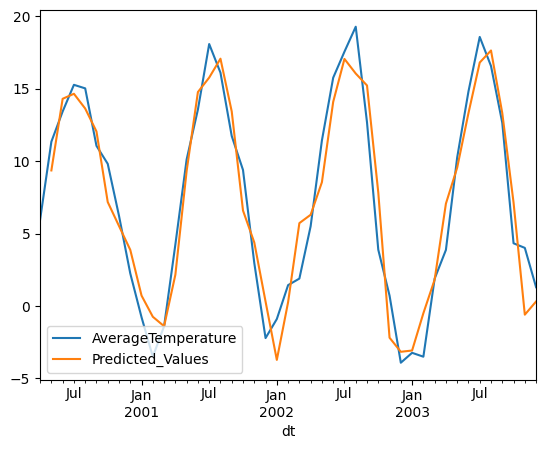

In [20]:
final_model[["AverageTemperature", "Predicted_Values"]].plot()

# What about an ARIMA model?

If we had to difference the data earlier, we would have to de-difference the data before plotting the data.

# What about future values?

In [21]:
# Define the number of future periods you want to predict
n_periods = 12  # Adjust this as needed

# Extend the date range to include future dates
last_date = df_testing.index.max()  # Get the last date in your DataFrame
future_dates = pd.date_range(start=last_date, periods=n_periods+1, freq='M')  # Adjust frequency as needed
future_dates = future_dates[1:]  # Exclude the last date (it's already in your DataFrame)

# Create a DataFrame for future predictions
future_df = pd.DataFrame(index=future_dates, columns=df_testing.columns)

In [22]:
future_df

,AverageTemperature
2004-01-31,NaN
2004-02-29,NaN
2004-03-31,NaN
2004-04-30,NaN
2004-05-31,NaN
2004-06-30,NaN
2004-07-31,NaN
2004-08-31,NaN
2004-09-30,NaN
2004-10-31,NaN


In [23]:
forecast_data = pd.concat([df_testing,future_df])

C:\Users\gaute\AppData\Local\Temp\ipykernel_38120\2677929634.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast_data = pd.concat([df_testing,future_df])


In [24]:
forecast_data

,AverageTemperature
2000-01-01,-0.0738
2000-02-01,0.3756
2000-03-01,1.5902
2000-04-01,5.9578
2000-05-01,11.3468
2000-06-01,13.4314
2000-07-01,15.2748
2000-08-01,15.0294
2000-09-01,11.0626
2000-10-01,9.8188


In [25]:
[df_ar,MSE,RMSE] = ARMA(df_testing,5,4)

The MSE is : 9.977471566097044 , Value of p :  5 Value of q : 4
The RMSE is : 3.158713593553085 , Value of p :  5 Value of q : 4


<Axes: xlabel='dt'>

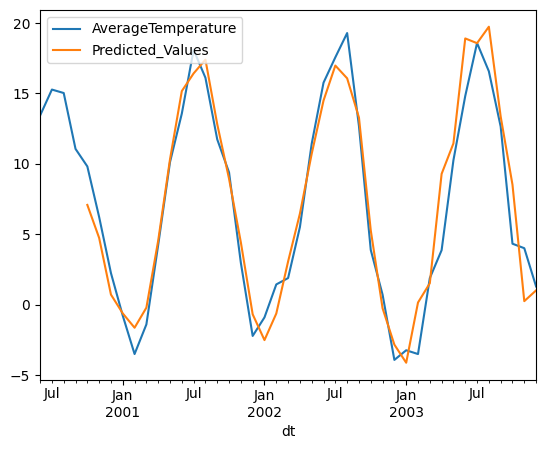

In [26]:
df_ar.dropna()
df_ar[['AverageTemperature','Predicted_Values']].plot()

In [50]:

def ARMA_forecast(df,p,q,forecast_periods):
    
    """
    Perform an AutoRegressive Moving Average (ARMA) analysis on a time series DataFrame.

    Args:
        df (pandas.DataFrame): A DataFrame containing a time series with a column named 'AverageTemperature'.
        p (int): The order of the AutoRegressive (AR) model.
        q (int): The order of the Moving Average (MA) model.

    Returns:
        list: A list containing the following items:
            1. pandas.DataFrame: A DataFrame with additional columns, including 'Predicted_Values', 
               representing the ARMA model predictions.
            2. float: Mean Squared Error (MSE) of the ARMA model on the testing data.
            3. float: Root Mean Squared Error (RMSE) of the ARMA model on the testing data.

    This function performs an ARMA analysis on a given time series data, consisting of AR (AutoRegressive) and 
    MA (Moving Average) modeling. It first extracts the AR component by fitting a linear regression model 
    to the lagged values of the 'AverageTemperature' series. Then, it calculates the residuals and uses them 
    for fitting the MA component with another linear regression model. Finally, it combines the AR and MA 
    components to generate predictions for the entire time series and returns the resulting DataFrame, 
    along with MSE and RMSE as evaluation metrics.

    Note:
    - The function assumes that the input DataFrame 'df' contains a column named 'AverageTemperature'.
    - The input 'p' and 'q' are positive integers specifying the orders of the AR and MA models, respectively.
    - The training-testing split is performed using an 80-20 ratio.
    - Linear regression models are used for parameter estimation.
    """
    
    #AR part
    # Copy the input DataFrame to avoid modifying the original data
    df_temp = df.copy()

    # Generate the lagged p terms
    for i in range(1, p + 1):
        df_temp['Shifted_values_%d' % i] = df_temp['AverageTemperature'].shift(i)

    # Determine the size of the training set (80% of the data)
    train_size = (int)(0.8 * df_temp.shape[0])

    # Split the data into training and testing sets
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    # Remove rows with missing values in the training set
    df_train_2 = df_train.dropna()

    # Extract lagged features (X) and target variable (y) for training
    X_train = df_train_2.iloc[:, 1:].values.reshape(-1, p)
    y_train = df_train_2.iloc[:, 0].values.reshape(-1, 1)

    # Apply linear regression to estimate AR model coefficients
    result = ols_linear_regression(X_train, y_train)
    coef = result[0]
    intercept = result[1]

    # Generate predictions for the training set
    df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)

    # Prepare lagged features for the testing set
    X_test = df_test.iloc[:, 1:].values.reshape(-1, p)

    # Generate predictions for the testing set
    df_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef, intercept)


    # Concatenate training and testing data for residuals calculation
    df_ar = pd.concat([df_train_2, df_test])

    # Calculate residuals
    res = pd.DataFrame()
    res['Residuals'] = df_ar['AverageTemperature'] - df_ar['Predicted_Values']
    
    
    # Generate lagged residuals as features
    for i in range(1, q + 1):
        res['Shifted_values_%d' % i] = res['Residuals'].shift(i)

    # Determine the size of the training set (80% of the data)
    train_size = (int)(0.8 * res.shape[0])

    # Split the data into training and testing sets
    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    # Remove rows with missing values in the training set
    res_train_2 = res_train.dropna()

    # Extract lagged residuals (X) and residuals (y) for training
    X_train = res_train_2.iloc[:, 1:].values.reshape(-1, q)
    y_train = res_train_2.iloc[:, 0].values.reshape(-1, 1)

    # Apply linear regression to estimate MA model coefficients
    result2 = ols_linear_regression(X_train, y_train)
    coef2 = result2[0]
    intercept2 = result2[1]

    # Generate predictions for the training set
    res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef2, intercept2)

    # Prepare lagged residuals for the testing set
    X_test = res_test.iloc[:, 1:].values.reshape(-1, q)

    # Generate predictions for the testing set
    res_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef2, intercept2)
    
    # Calculate RMSE and MSE to evaluate model performance
    MSE = mean_squared_error(res_test['Residuals'], res_test['Predicted_Values'])
    RMSE = np.sqrt(MSE)

    # Print RMSE and order of the MA model
    print("The MSE is :", MSE,", Value of p : ",p, "Value of q :",q)
    print("The RMSE is :", RMSE,", Value of p : ",p, "Value of q :",q)
    
    # Pediction
    res_c = pd.concat([res_train_2,res_test])
    
    # Adding the predicted data from res to the AR part (ARMA)
    df_ar.Predicted_Values += res_c.Predicted_Values
    
    last_date = df_testing.index.max()  # Get the last date in your DataFrame
    future_dates = pd.date_range(start=last_date, periods=forecast_periods, freq='M')  # Adjust frequency as needed
    future_dates = future_dates[1:]  # Exclude the last date (it's already in your DataFrame)

    # Create a DataFrame for future predictions
    future_df = pd.DataFrame(index=future_dates, columns=df_testing.columns)

    # Initialize the future DataFrame with NaN values
    #future_df['dt'] = future_df.index
    future_df['AverageTemperature'] = 0
    future_df['Predicted_Values'] = np.nan

    #df_ar
    # # Combine the original DataFrame and the future DataFrame
    final_df = pd.concat([df_ar, future_df])
    final_df= final_df[["AverageTemperature"]]
    final_df
    # Create an empty list to store the forecasted values
    # forecasted_values = []

    df_temp2 = final_df.copy()
    df_temp2.dropna()

    [df_final,MSE,RMSE] = ARMA(df_temp2,p,q)
    
        #forecast_series = pd.Series(forecast_values)

    return [df_final, MSE, RMSE]
    #df_c[['AverageTemperature','Predicted_Values']]
   

In [62]:
[df_ar,MSE,RMSE] = ARMA_forecast(df_testing2,12,12,12)

The MSE is : 3.7452968544727994 , Value of p :  12 Value of q : 12
The RMSE is : 1.9352769451612861 , Value of p :  12 Value of q : 12
The MSE is : 6.310844401377102 , Value of p :  12 Value of q : 12
The RMSE is : 2.5121394072338226 , Value of p :  12 Value of q : 12


C:\Users\gaute\AppData\Local\Temp\ipykernel_38120\2549052593.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)
C:\Users\gaute\AppData\Local\Temp\ipykernel_38120\2549052593.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef2, intercept2)


In [63]:
df_ar

,AverageTemperature,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
1952-01-01,-1.9576,2.1216,4.0150,7.5472,12.7410,16.2174,15.1880,13.2546,7.7058,3.7560,-3.1376,-1.8150,-3.7914,NaN
1952-02-01,-1.7788,-1.9576,2.1216,4.0150,7.5472,12.7410,16.2174,15.1880,13.2546,7.7058,3.7560,-3.1376,-1.8150,NaN
1952-03-01,-2.6922,-1.7788,-1.9576,2.1216,4.0150,7.5472,12.7410,16.2174,15.1880,13.2546,7.7058,3.7560,-3.1376,NaN
1952-04-01,5.6554,-2.6922,-1.7788,-1.9576,2.1216,4.0150,7.5472,12.7410,16.2174,15.1880,13.2546,7.7058,3.7560,NaN
1952-05-01,8.6552,5.6554,-2.6922,-1.7788,-1.9576,2.1216,4.0150,7.5472,12.7410,16.2174,15.1880,13.2546,7.7058,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-07-31,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.2190,17.3276,14.8738,11.9138,3.3374,-3.5812,2.394408
2004-08-31,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.2190,17.3276,14.8738,11.9138,3.3374,3.890621
2004-09-30,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.2190,17.3276,14.8738,11.9138,7.401325
2004-10-31,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.2190,17.3276,14.8738,9.652974


In [38]:

p = 5
q = 4

df_temp = df_testing.copy()

# Generate the lagged p terms
for i in range(1, p + 1):
    df_temp['Shifted_values_%d' % i] = df_temp['AverageTemperature'].shift(i)

# Determine the size of the training set (80% of the data)
train_size = (int)(0.8 * df_temp.shape[0])

# Split the data into training and testing sets
df_train = pd.DataFrame(df_temp[0:train_size])
df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

# Remove rows with missing values in the training set
df_train_2 = df_train.dropna()

# Extract lagged features (X) and target variable (y) for training
X_train = df_train_2.iloc[:, 1:].values.reshape(-1, p)
y_train = df_train_2.iloc[:, 0].values.reshape(-1, 1)

# Apply linear regression to estimate AR model coefficients
result = ols_linear_regression(X_train, y_train)
coef = result[0]
intercept = result[1]

# Generate predictions for the training set
df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)

# Prepare lagged features for the testing set
X_test = df_test.iloc[:, 1:].values.reshape(-1, p)

# Generate predictions for the testing set
df_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef, intercept)


# Concatenate training and testing data for residuals calculation
df_ar = pd.concat([df_train_2, df_test])

# Calculate residuals
res = pd.DataFrame()
res['Residuals'] = df_ar['AverageTemperature'] - df_ar['Predicted_Values']


# Generate lagged residuals as features
for i in range(1, q + 1):
    res['Shifted_values_%d' % i] = res['Residuals'].shift(i)

# Determine the size of the training set (80% of the data)
train_size = (int)(0.8 * res.shape[0])

# Split the data into training and testing sets
res_train = pd.DataFrame(res[0:train_size])
res_test = pd.DataFrame(res[train_size:res.shape[0]])

# Remove rows with missing values in the training set
res_train_2 = res_train.dropna()

# Extract lagged residuals (X) and residuals (y) for training
X_train = res_train_2.iloc[:, 1:].values.reshape(-1, q)
y_train = res_train_2.iloc[:, 0].values.reshape(-1, 1)

# Apply linear regression to estimate MA model coefficients
result2 = ols_linear_regression(X_train, y_train)
coef2 = result2[0]
intercept2 = result2[1]

# Generate predictions for the training set
res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef2, intercept2)

# Prepare lagged residuals for the testing set
X_test = res_test.iloc[:, 1:].values.reshape(-1, q)

# Generate predictions for the testing set
res_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef2, intercept2)

# Pediction
res_c = pd.concat([res_train_2,res_test])

# Adding the predicted data from res to the AR part (ARMA)
df_ar.Predicted_Values += res_c.Predicted_Values


last_date = df_testing.index.max()  # Get the last date in your DataFrame
future_dates = pd.date_range(start=last_date, periods=12, freq='M')  # Adjust frequency as needed
future_dates = future_dates[1:]  # Exclude the last date (it's already in your DataFrame)

# Create a DataFrame for future predictions
future_df = pd.DataFrame(index=future_dates, columns=df_testing.columns)

# Initialize the future DataFrame with NaN values
#future_df['dt'] = future_df.index
future_df['AverageTemperature'] = 0
future_df['Predicted_Values'] = np.nan

#df_ar
# # Combine the original DataFrame and the future DataFrame
final_df = pd.concat([df_ar, future_df])
final_df= final_df[["AverageTemperature"]]
final_df
# Create an empty list to store the forecasted values
# forecasted_values = []

df_temp2 = final_df.copy()
df_temp2.dropna()

# # Generate the lagged p terms
# for i in range(1, p + 1):
#     df_temp2['Shifted_values_%d' % i] = df_temp2['AverageTemperature'].shift(i)

# # Determine the size of the training set (80% of the data)
# train_size = (int)(0.8 * df_temp2.shape[0])

# # Split the data into training and testing sets
# df_train = pd.DataFrame(df_temp2[0:train_size])
# df_test = pd.DataFrame(df_temp2[train_size:df.shape[0]])

# # Remove rows with missing values in the training set
# df_train_2 = df_train.dropna()

# # Extract lagged features (X) and target variable (y) for training
# X_train = df_train_2.iloc[:, 1:].values.reshape(-1, p)
# y_train = df_train_2.iloc[:, 0].values.reshape(-1, 1)

# # Apply linear regression to estimate AR model coefficients
# result = ols_linear_regression(X_train, y_train)
# coef = result[0]
# intercept = result[1]

# # Generate predictions for the training set
# df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)

# # Prepare lagged features for the testing set
# X_test = df_test.iloc[:, 1:].values.reshape(-1, p)

# # Generate predictions for the testing set
# df_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef, intercept)


# # Concatenate training and testing data for residuals calculation
# df_ar = pd.concat([df_train_2, df_test])

# # Calculate residuals
# res = pd.DataFrame()
# res['Residuals'] = df_ar['AverageTemperature'] - df_ar['Predicted_Values']


# # Generate lagged residuals as features
# for i in range(1, q + 1):
#     res['Shifted_values_%d' % i] = res['Residuals'].shift(i)

# # Determine the size of the training set (80% of the data)
# train_size = (int)(0.8 * res.shape[0])

# # Split the data into training and testing sets
# res_train = pd.DataFrame(res[0:train_size])
# res_test = pd.DataFrame(res[train_size:res.shape[0]])

# # Remove rows with missing values in the training set
# res_train_2 = res_train.dropna()

# # Extract lagged residuals (X) and residuals (y) for training
# X_train = res_train_2.iloc[:, 1:].values.reshape(-1, q)
# y_train = res_train_2.iloc[:, 0].values.reshape(-1, 1)

# # Apply linear regression to estimate MA model coefficients
# result2 = ols_linear_regression(X_train, y_train)
# coef2 = result2[0]
# intercept2 = result2[1]

# # Generate predictions for the training set
# res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef2, intercept2)

# # Prepare lagged residuals for the testing set
# X_test = res_test.iloc[:, 1:].values.reshape(-1, q)

# # Generate predictions for the testing set
# res_test['Predicted_Values'] = predict_ols_linear_regression(X_test, coef2, intercept2)

# # Pediction
# res_c = pd.concat([res_train_2,res_test])

# # Adding the predicted data from res to the AR part (ARMA)
# df_ar.Predicted_Values += res_c.Predicted_Values

# df_ar
# # Initialize the model with the last available data point
# last_data_point = df_ar['Predicted_Values'].iloc[-1]

# # Loop through the future dates
# for i, date in enumerate(future_dates):
#     ar_component = 0
#     ma_component = 0

#     # Calculate the AR component for each lag value (p)
#     for lag in range(1, p + 1):
#         ar_component += coef[lag - 1] * last_data_point

#     # Calculate the MA component for each lag value (q)
#     for lag in range(1, q + 1):
#         ma_component += coef2[lag - 1] * (last_data_point - intercept2)

#     # Calculate the next forecasted value
#     forecasted_value = last_data_point + ar_component - ma_component

#     # Append the forecasted value to the list
#     forecasted_values.append(forecasted_value)

#     # Update the last data point for the next iteration
#     last_data_point = forecasted_value

# # Create a DataFrame for the forecasted values
# forecasted_df = pd.DataFrame({'Predicted_Values': forecasted_values}, index=future_dates)

# forecasted_df

C:\Users\gaute\AppData\Local\Temp\ipykernel_38120\2771105522.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef, intercept)
C:\Users\gaute\AppData\Local\Temp\ipykernel_38120\2771105522.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = predict_ols_linear_regression(X_train, coef2, intercept2)


,AverageTemperature
2000-06-01,13.4314
2000-07-01,15.2748
2000-08-01,15.0294
2000-09-01,11.0626
2000-10-01,9.8188
2000-11-01,6.2276
2000-12-01,2.2456
2001-01-01,-0.7798
2001-02-01,-3.5006
2001-03-01,-1.3970


In [48]:
[df_ar,MSE,RMSE] = ARMA(df_temp2,11,11)

The MSE is : 52.31534585684942 , Value of p :  11 Value of q : 11
The RMSE is : 7.232934802474679 , Value of p :  11 Value of q : 11


<Axes: >

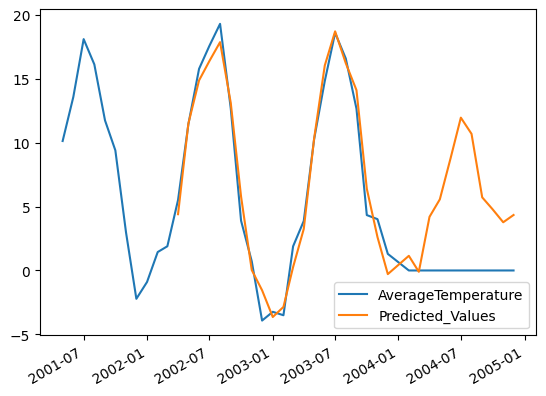

In [49]:
df_ar[["AverageTemperature","Predicted_Values"]].plot()

In [31]:
import numpy as np

def simple_linear_regression(X, y):
    """
    Perform simple linear regression.

    Parameters:
    X (numpy.ndarray): Independent variable (predictor).
    y (numpy.ndarray): Dependent variable (target).

    Returns:
    tuple: (slope, intercept)
    """
    # Calculate the mean of X and y
    mean_x = np.mean(X)
    mean_y = np.mean(y)

    # Calculate the deviations from the mean
    dev_x = X - mean_x
    dev_y = y - mean_y

    # Calculate the slope (m)
    slope = np.sum(dev_x * dev_y) / np.sum(dev_x * dev_x)

    # Calculate the intercept (b)
    intercept = mean_y - slope * mean_x

    return slope, intercept

def forecast(X, slope, intercept):
    """
    Forecast values using linear regression.

    Parameters:
    X (numpy.ndarray): Independent variable (predictor).
    slope (float): Slope of the regression line.
    intercept (float): Intercept of the regression line.

    Returns:
    numpy.ndarray: Forecasted values.
    """
    return slope * X + intercept

# Example usage:
if __name__ == "__main__":
    # Sample data
    X = np.array([1, 2, 3, 4, 5])
    y = np.array([2, 3, 4, 5, 6])

    # Perform linear regression
    slope, intercept = simple_linear_regression(X, y)

    # Forecast a new value
    new_x = 9
    forecasted_y = forecast(new_x, slope, intercept)
    print(f"Forecasted value for X={new_x}: {forecasted_y:.2f}")

Forecasted value for X=9: 10.00
